In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/Colab Notebooks/DIP_A2_AhmadBabar/wbc_data"
train_path = os.path.join(data_dir, "Train")
test_path = os.path.join(data_dir, "Test")

wbc_classes = ["Basophil", "Eosinophil", "Lymphocyte", "Monocyte", "Neutrophil"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#resize, denoise- convert g scale
    def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    return img, img_gray


In [ ]:
#7 feature 3 color 4 texture
def extract_features(img, img_gray):
    features = []

    # Color features
    mean_color = cv2.mean(img)[:3]
    features.extend(mean_color)

    # Texture features using GLCM
    glcm = graycomatrix(img_gray, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    features.extend([contrast, homogeneity, energy, correlation])

    return features


In [ ]:
def load_dataset(folder_path):
    X = []
    y = []

    for label in wbc_classes:
        class_dir = os.path.join(folder_path, label)
        for img_file in tqdm(os.listdir(class_dir), desc=f"Loading {label}"):
            img_path = os.path.join(class_dir, img_file)
            img, img_gray = preprocess_image(img_path)
            features = extract_features(img, img_gray)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

# Load training and test data
X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

# Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


Loading Neutrophil: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_enc)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


Overall Accuracy: 47.60%


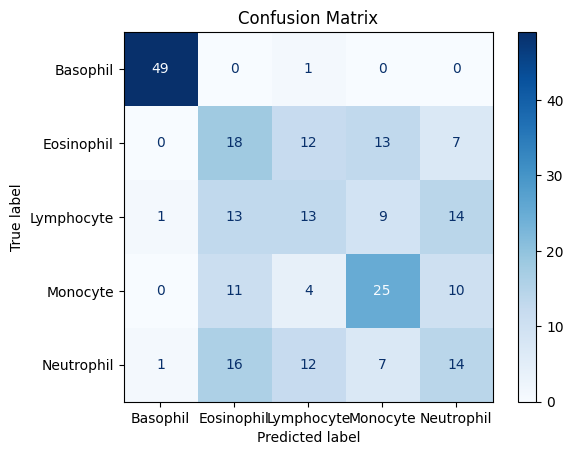

Basophil Accuracy: 98.00%
Eosinophil Accuracy: 36.00%
Lymphocyte Accuracy: 26.00%
Monocyte Accuracy: 50.00%
Neutrophil Accuracy: 28.00%


In [ ]:
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"{encoder.classes_[i]} Accuracy: {acc*100:.2f}%")


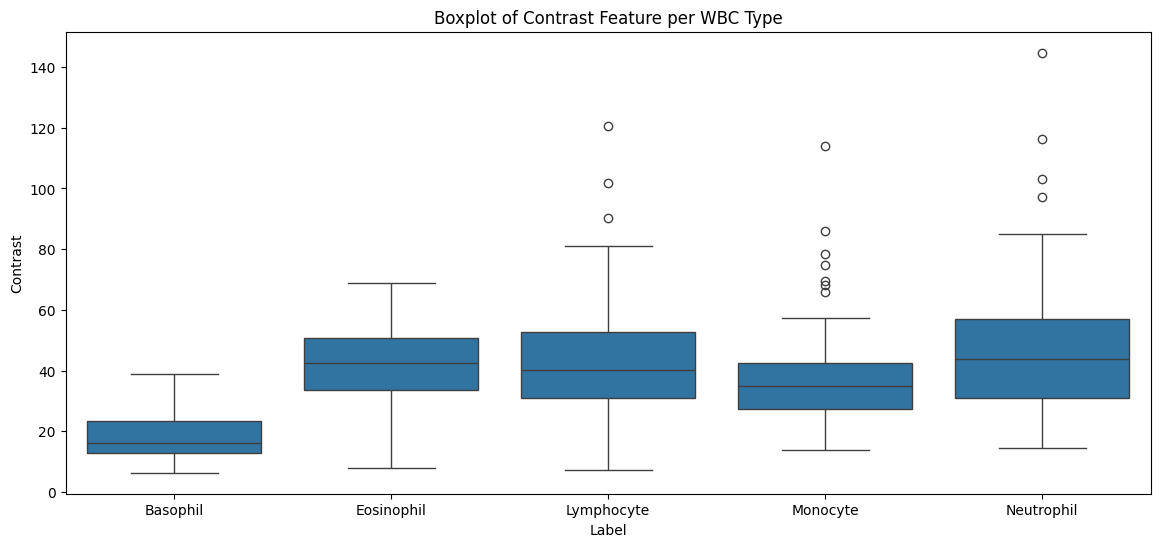

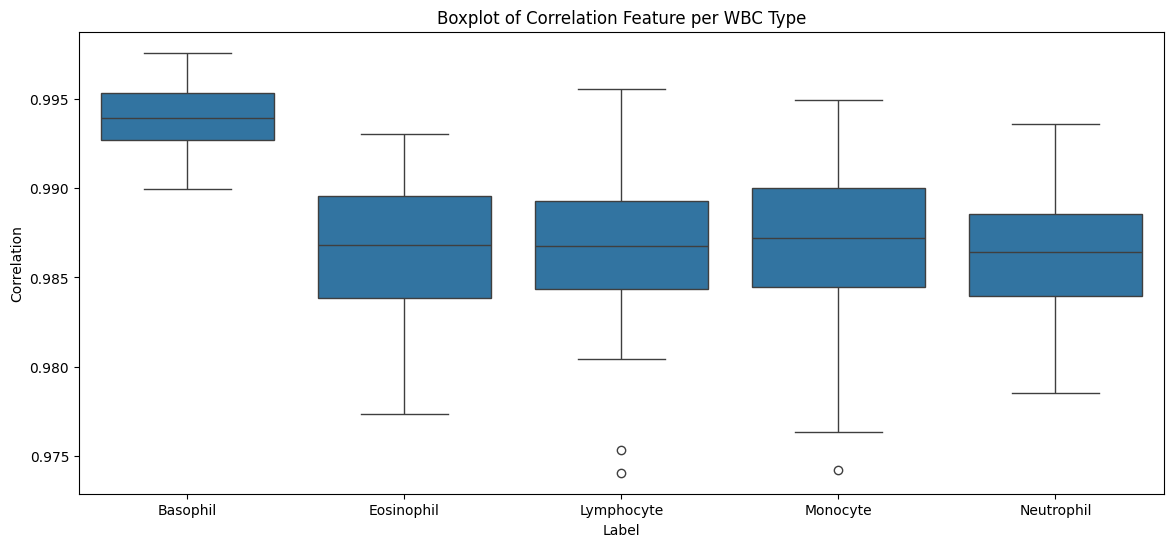

In [ ]:
# Visualize distribution of features
import pandas as pd

df = pd.DataFrame(X_train, columns=[
    "Mean_R", "Mean_G", "Mean_B", "Contrast", "Homogeneity", "Energy", "Correlation"
])
df["Label"] = y_train

# Boxplot of key features
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Label", y="Contrast")
plt.title("Boxplot of Contrast Feature per WBC Type")
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Label", y="Correlation")
plt.title("Boxplot of Correlation Feature per WBC Type")
plt.show()


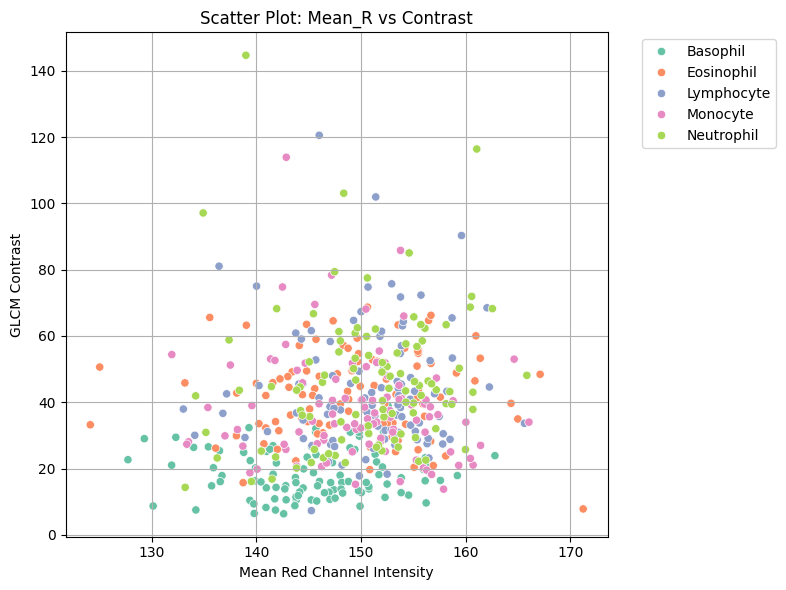

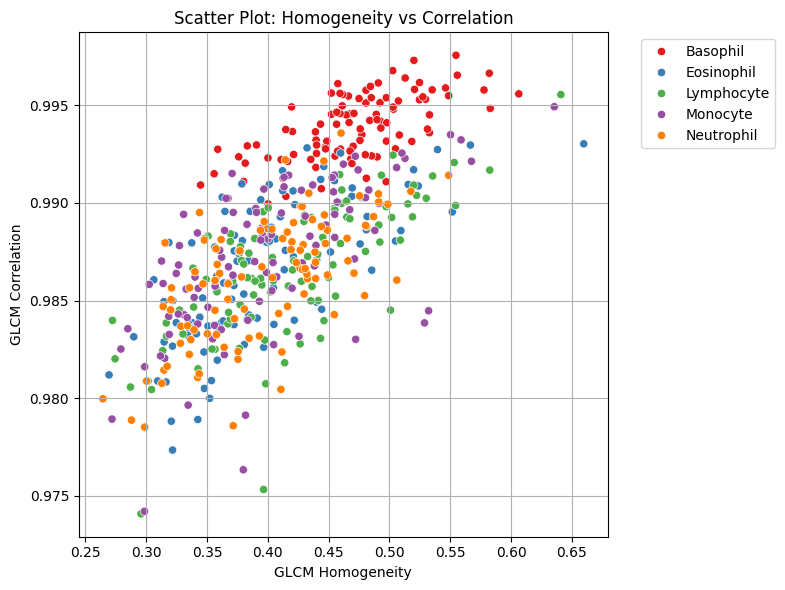

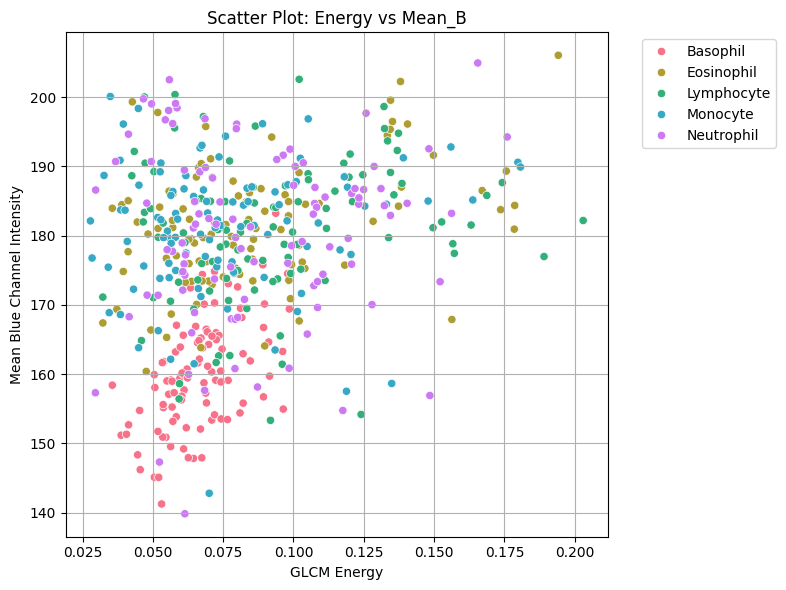

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame for visualization
columns = ["Mean_R", "Mean_G", "Mean_B", "Contrast", "Homogeneity", "Energy", "Correlation"]
df = pd.DataFrame(X_train, columns=columns)
df['Label'] = y_train

# Scatter Plot: Mean_R vs Contrast
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Mean_R", y="Contrast", hue="Label", palette="Set2")
plt.title("Scatter Plot: Mean_R vs Contrast")
plt.xlabel("Mean Red Channel Intensity")
plt.ylabel("GLCM Contrast")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Homogeneity vs Correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Homogeneity", y="Correlation", hue="Label", palette="Set1")
plt.title("Scatter Plot: Homogeneity vs Correlation")
plt.xlabel("GLCM Homogeneity")
plt.ylabel("GLCM Correlation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Energy vs Mean_B
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Energy", y="Mean_B", hue="Label", palette="husl")
plt.title("Scatter Plot: Energy vs Mean_B")
plt.xlabel("GLCM Energy")
plt.ylabel("Mean Blue Channel Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
